# Clasificación multi-clase usando redes neuronales

En esta pregunta, experimentará con una red neuronal en el contexto de clasificación de textos, donde un documento puede pertenecer a una de varias categorías posibles. El objetivo principal es que prueben diferentes hiperparámetros de manera sistemática para que propongan una configuración de red que esté debidamente justificada. Experimentará con el conjunto de datos de Reuters, que se puede cargar directamente desde Keras:

In [3]:
from keras.datasets import reuters
(train_data, train_labels), (val_data, val_labels) = reuters.load_data(num_words=10000)
(viz_train_data, viz_train_labels), (val_data, val_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


Este dataset tiene 11228 noticias las cuales pertenecen a una de 46 categorías posibles. 
Transformamos las etiquetas para que en lugar de que tengan un id de categoría, tengan un vector one-hot (pueden ver los contenidos de train_labels antes y después de la transformación)

In [4]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
train_labels.shape

(8982, 46)

Cada documento está descripto por una lista que contiene los ids de las palabras que contine. Procesaremos todos los documentos formando una matriz en donde cada fila será un documento y cada columna una palabra. En cada celda (*i,j*) tendremos un 1 o un 0 dependiendo si la palabra *j* de esa columna aparece en el documento de esa fila *i*. Pueden ver los contenidos de train_data antes y después de la transformación.

In [5]:
import numpy as np

In [6]:
def vectorize_data(data, features=10000):
    vectorized_data = np.zeros((len(data), features))
    for i, data_instance in enumerate(data):
        vectorized_data[i, data_instance] = 1
    return vectorized_data

train_data = vectorize_data(train_data)
val_data = vectorize_data(val_data)

## Experimentación con múltiples hiperparámetros.

Construya una red neuronal para el problema en cuestión. Pruebe con diferentes hiperparámetros y reporte la mejor performance encontrada. Los hiperparámetros más importantes para esta pregunta son: número de capas, cantidad de nodos por capa, learning rate y número de épocas.

**Consejo**: Intente modularizar el código para poder realizar los experimentos de forma ordenada.

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

num_of_features = 10000
num_of_categories = 46

input_tensor = layers.Input(shape=(num_of_features,))
x = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(num_of_categories, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer='rmsprop', # ej, descenso de gradiente
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [9]:
print(train_data.shape)
print(train_labels.shape)

(8982, 10000)
(8982, 46)


In [10]:
model.fit(train_data, train_labels, epochs=5, batch_size=128)

Epoch 1/5
71/71 [==============================] - 2s 21ms/step - loss: 2.0866 - accuracy: 0.6123
Epoch 2/5
71/71 [==============================] - 2s 21ms/step - loss: 1.1240 - accuracy: 0.7660
Epoch 3/5
71/71 [==============================] - 1s 14ms/step - loss: 0.8294 - accuracy: 0.8261
Epoch 4/5
71/71 [==============================] - 1s 14ms/step - loss: 0.6431 - accuracy: 0.8663
Epoch 5/5
71/71 [==============================] - 1s 15ms/step - loss: 0.5094 - accuracy: 0.8941


In [11]:
test_loss, test_acc = model.evaluate(val_data, val_labels)
print('test_acc: ', test_acc)
print('test_loss:', test_loss)

71/71 [==============================] - 0s 3ms/step - loss: 0.8892 - accuracy: 0.7930
test_acc:  0.792965292930603
test_loss: 0.8891912698745728


In [16]:
from tensorflow import random

def train_and_test_net(n_feat:int,
                       n_cat:int,
                       train_data,
                       train_lab,
                       test_data,
                       test_lab,
                       layers_conf:[],
                       epocs:int,
                       batch_size:int,
                       optimizer,
                       loss:str,
                       metrics:[],
                       activation:str,
                       seed:int = 55
                       ):
    random.set_seed(seed)
    layers_ = [layers.Input(shape=(num_of_features,))]
    for i, l_conf in enumerate(layers_conf):
        if l_conf["activation"] == "leakyrelu":
            x = layers.Dense(l_conf["nodes"])(layers_[i])
            x = layers.LeakyReLU(alpha=0.3)(x)
            layers_.append(x)
        else:
            if l_conf.get("dropout"): 
                x = layers.Dense(
                    l_conf["nodes"],
                    activation=l_conf["activation"],
                    kernel_regularizer=l_conf.get("kernel_regularizer")
                    )(layers_[i])
                x = layers.Dropout(rate=l_conf["dropout"])(x)
                layers_.append(x)
            else:
                layers_.append(layers.Dense(
                    l_conf["nodes"],
                    activation=l_conf["activation"],
                    kernel_regularizer=l_conf.get("kernel_regularizer")
                    )(layers_[i]))
    output_tensor = layers.Dense(num_of_categories, activation=activation)(layers_[-1])

    model = models.Model(inputs=layers_[0], outputs=output_tensor)
    model.compile(optimizer=optimizer, # ej, descenso de gradiente
                    loss=loss,
                    metrics=metrics)
    history = model.fit(train_data, train_lab, epochs=epocs, batch_size=batch_size, verbose=False, validation_data=(test_data, test_lab))
    test_loss, test_acc = model.evaluate(test_data, test_lab)
    args_selected = locals()
    ignore_args = ["n_feat","n_cat", "train_data", "train_lab", "test_data", "test_lab"]
    args_selected = [{k:v} for k,v in args_selected.items() if k not in ignore_args]
    print(f"Argumentos seleccionados: {args_selected}")
    print('test_acc:', test_acc)
    print('test_loss:', test_loss)
    print('----------------------')
    return history


In [15]:
for nr_seed in [1,10,100,1000,5,55,85]:
    train_and_test_net(num_of_features,
                    num_of_categories,
                    train_data,
                    train_labels,
                    val_data,
                    val_labels,
                    layers_conf=[{
                        "nodes":32,
                            "activation": "relu"
                    }],
                    epocs=10,
                    batch_size=128,
                    optimizer="rmsprop",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"],
                    activation="softmax",
                    seed=nr_seed
                    )

71/71 [==============================] - 0s 3ms/step - loss: 0.9458 - accuracy: 0.8001
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu'}]}, {'epocs': 10}, {'batch_size': 128}, {'optimizer': 'rmsprop'}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 1}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_4')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_8')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu'}}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_9')>}, {'model': <keras.engine.functional.Functional object at 0x7ff111b4ff90>}, {'history': <keras.callbacks.History object at 0x7ff11198fa90>}, {'test_loss': 0.9458430409431458}, {'test_acc': 0.8000890612602234}]
test_acc: 0.8000890612602234
test_loss: 0.9458430409431458
----------------------
71/71 [==============================] - 0s 3ms/s

La semilla nro 55 nos da la mejor combinación de accuracy y de test loss.
Se agrega como valor por defecto en la función "train_and_test_net".

In [17]:
# Probando diferentes números de capas
combinations = [
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}, { "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}, { "nodes":32, "activation": "relu"},{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    
]

for comb in combinations:
    train_and_test_net(
        num_of_features,
        num_of_categories,
        train_data,
        train_labels,
        val_data,
        val_labels,
        ** comb
    )


71/71 [==============================] - 0s 3ms/step - loss: 0.9065 - accuracy: 0.8077
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu'}]}, {'epocs': 10}, {'batch_size': 128}, {'optimizer': 'rmsprop'}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_11')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_22')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu'}}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_23')>}, {'model': <keras.engine.functional.Functional object at 0x7ff1115c93d0>}, {'history': <keras.callbacks.History object at 0x7ff1107dc2d0>}, {'test_loss': 0.9065453410148621}, {'test_acc': 0.8076580762863159}]
test_acc: 0.8076580762863159
test_loss: 0.9065453410148621
----------------------
71/71 [==============================] - 0s 3

Observaciones de las pruebas:
Mas layers NO ayuda a mejorar la accuracy.



In [18]:
# Probando número de nodos por capa
combinations = [
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":64, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":128, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    
]

for comb in combinations:
    train_and_test_net(
        num_of_features,
        num_of_categories,
        train_data,
        train_labels,
        val_data,
        val_labels,
        ** comb
    )


71/71 [==============================] - 0s 3ms/step - loss: 0.9065 - accuracy: 0.8077
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu'}]}, {'epocs': 10}, {'batch_size': 128}, {'optimizer': 'rmsprop'}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_14')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_31')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu'}}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_32')>}, {'model': <keras.engine.functional.Functional object at 0x7ff111e4aed0>}, {'history': <keras.callbacks.History object at 0x7ff111da8310>}, {'test_loss': 0.9065453410148621}, {'test_acc': 0.8076580762863159}]
test_acc: 0.8076580762863159
test_loss: 0.9065453410148621
----------------------
71/71 [==============================] - 0s 4

Aumentar el número de nodos no ayuda a la accuracy.

In [45]:
# Funciones de
combinations = [
    {
        "layers_conf":[{ "nodes":32, "activation": "leakyrelu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "linear"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },    
    {
        "layers_conf":[{ "nodes":32, "activation": "sigmoid"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },    
]

for comb in combinations:
    train_and_test_net(
        num_of_features,
        num_of_categories,
        train_data,
        train_labels,
        val_data,
        val_labels,
        ** comb
    )


71/71 [==============================] - 0s 3ms/step - loss: 0.9095 - accuracy: 0.8072
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'leakyrelu'}]}, {'epocs': 10}, {'batch_size': 128}, {'optimizer': 'rmsprop'}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_59')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'leaky_re_lu_2')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'leakyrelu'}}, {'x': <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'leaky_re_lu_2')>}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_122')>}, {'model': <keras.engine.functional.Functional object at 0x7ff112029e90>}, {'history': <keras.callbacks.History object at 0x7ff111706ed0>}, {'test_loss': 0.9095311760902405}, {'test_acc': 0.8072128295898438}]
test_acc: 0.8072128295

La función de activación relu mejora levemente la performance frente a linear, leakyrelu y sigmoid. Para las próximas pruebas, se mantiene este parámetro.

In [21]:
combinations = [
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 20,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },    
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 30,
        "batch_size": 128,
        "optimizer": "rmsprop",
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },    
]

for comb in combinations:
    train_and_test_net(
        num_of_features,
        num_of_categories,
        train_data,
        train_labels,
        val_data,
        val_labels,
        ** comb
    )


71/71 [==============================] - 0s 5ms/step - loss: 0.9065 - accuracy: 0.8077
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu'}]}, {'epocs': 10}, {'batch_size': 128}, {'optimizer': 'rmsprop'}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_22')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_47')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu'}}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_48')>}, {'model': <keras.engine.functional.Functional object at 0x7ff111587f50>}, {'history': <keras.callbacks.History object at 0x7ff110514fd0>}, {'test_loss': 0.9065453410148621}, {'test_acc': 0.8076580762863159}]
test_acc: 0.8076580762863159
test_loss: 0.9065453410148621
----------------------
71/71 [==============================] - 1s 6

A más epocs de 10 epocs, menos performance.

In [22]:
from tensorflow.keras import optimizers

combinations = [
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.01),
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.0001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },    
    {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 10,
        "batch_size": 128,
        "optimizer": optimizers.Adam(),
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
]

for comb in combinations:
    train_and_test_net(
        num_of_features,
        num_of_categories,
        train_data,
        train_labels,
        val_data,
        val_labels,
        ** comb
    )


71/71 [==============================] - 0s 3ms/step - loss: 0.9065 - accuracy: 0.8077
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu'}]}, {'epocs': 10}, {'batch_size': 128}, {'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x7ff111994990>}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_25')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_53')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu'}}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_54')>}, {'model': <keras.engine.functional.Functional object at 0x7ff1128a7410>}, {'history': <keras.callbacks.History object at 0x7ff112943390>}, {'test_loss': 0.9065453410148621}, {'test_acc': 0.8076580762863159}]
test_acc: 0.8076580762863159
test_loss: 0.9065453410148621
-----

Como conclusión de la primer pasada, el parámetro que mas ayudó a mejorar es el de usar una activación relu para cada nodo con una semilla número 55. El resto de los hiper parámetros no hicieron una diferencia, de hecho empeoraron los resultados. Inicialmente había intentado con una semilla distinta, lo que me habia arrojado que una función de activación lineal era la mejor, pero al seleccionar 55 de semilla, la activación relu es la que mejor performó. De todas formas las diferencias encontradas eran muy menores, por lo que ninguna generó un gran cambio.


## Tamaño de mini-batch
Describa cómo cambia la convergencia al utilizar distintos valores de mini-batch. Un gráfico que muestre el costo/pérdida en función del número de épocas sería suficiente

In [23]:
import matplotlib.pyplot as plt


from tensorflow.keras import optimizers

combination0 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 8,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination1 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 16,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination2 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 32,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination3 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 64,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination4 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination5 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 256,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination6 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 512,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination7 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 1024,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
combination8 = {
        "layers_conf":[{ "nodes":32, "activation": "relu"}],
        "epocs": 15,
        "batch_size": 2048,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }


history0 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination0
)
history1 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination1
)
history2 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination2
)
history3 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination3
)
history4 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination4
)
history5 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination5
)
history6 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination6
)
history7 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination7
)
history8 = train_and_test_net(
    num_of_features,
    num_of_categories,
    train_data,
    train_labels,
    val_data,
    val_labels,
    ** combination8
)
acc = history0.history['accuracy']

loss0 = history0.history['loss']
val_loss0 = history0.history['val_loss']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
loss4 = history3.history['loss']
val_loss4 = history4.history['val_loss']
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']
loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']
loss7 = history7.history['loss']
val_loss7 = history7.history['val_loss']
loss8 = history8.history['loss']
val_loss8 = history8.history['val_loss']
epochs = range(1, len(acc) + 1)

71/71 [==============================] - 0s 3ms/step - loss: 4.0067 - accuracy: 0.7689
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu'}]}, {'epocs': 15}, {'batch_size': 8}, {'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x7ff111ebf250>}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_29')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_61')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu'}}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_62')>}, {'model': <keras.engine.functional.Functional object at 0x7ff111ebf950>}, {'history': <keras.callbacks.History object at 0x7ff111ea7690>}, {'test_loss': 4.006709098815918}, {'test_acc': 0.7689225077629089}]
test_acc: 0.7689225077629089
test_loss: 4.006709098815918
---------

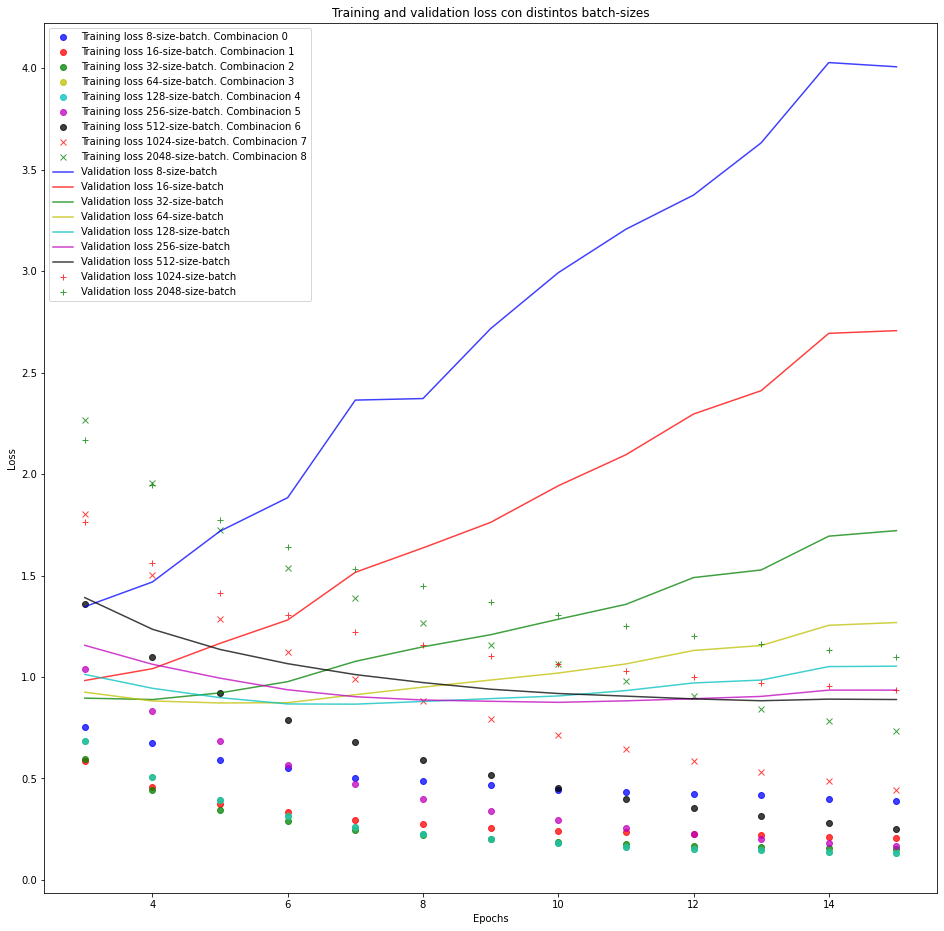

In [37]:
plt.figure(figsize=(16,16)) 
# "bo" is for "blue dot"
plt.plot(epochs[2:], loss0[2:], 'bo', label='Training loss 8-size-batch. Combinacion 0', alpha=0.75)
plt.plot(epochs[2:], loss1[2:], 'ro', label='Training loss 16-size-batch. Combinacion 1', alpha=0.75)
plt.plot(epochs[2:], loss2[2:], 'go', label='Training loss 32-size-batch. Combinacion 2', alpha=0.75)
plt.plot(epochs[2:], loss3[2:], 'yo', label='Training loss 64-size-batch. Combinacion 3', alpha=0.75)
plt.plot(epochs[2:], loss4[2:], 'co', label='Training loss 128-size-batch. Combinacion 4', alpha=0.75)
plt.plot(epochs[2:], loss5[2:], 'mo', label='Training loss 256-size-batch. Combinacion 5', alpha=0.75)
plt.plot(epochs[2:], loss6[2:], 'ko', label='Training loss 512-size-batch. Combinacion 6', alpha=0.75)
plt.plot(epochs[2:], loss7[2:], 'rx', label='Training loss 1024-size-batch. Combinacion 7', alpha=0.75)
plt.plot(epochs[2:], loss8[2:], 'gx', label='Training loss 2048-size-batch. Combinacion 8', alpha=0.75)
# b is for "solid blue line"
plt.plot(epochs[2:], val_loss0[2:], 'b', label='Validation loss 8-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss1[2:], 'r', label='Validation loss 16-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss2[2:], 'g', label='Validation loss 32-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss3[2:], 'y', label='Validation loss 64-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss4[2:], 'c', label='Validation loss 128-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss5[2:], 'm', label='Validation loss 256-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss6[2:], 'k', label='Validation loss 512-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss7[2:], 'r+', label='Validation loss 1024-size-batch', alpha=0.75)
plt.plot(epochs[2:], val_loss8[2:], 'g+', label='Validation loss 2048-size-batch', alpha=0.75)
plt.title('Training and validation loss con distintos batch-sizes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [36]:
for i, h in enumerate([history0, history1, history2, history3, history4, history5, history6, history7, history8]):
    epoch_min = np.argmin(h.history["val_loss"])
    print(f'----- Combinación {i}: \nValidation Loss: {h.history["val_loss"][epoch_min]}'
            f'\nTraining Loss: {h.history["loss"][epoch_min]}'
            f'\nAccuracy: {h.history["accuracy"][epoch_min]})'
            f'\nMejor Epoch: {epoch_min}')


----- Combinación 0: 
Validation Loss: 1.152512788772583
Training Loss: 1.3887343406677246
Accuracy: 0.7032954692840576)
Mejor Epoch: 0
----- Combinación 1: 
Validation Loss: 0.9827789664268494
Training Loss: 0.5874143838882446
Accuracy: 0.8769761919975281)
Mejor Epoch: 2
----- Combinación 2: 
Validation Loss: 0.8889188170433044
Training Loss: 0.4410998821258545
Accuracy: 0.9055889844894409)
Mejor Epoch: 3
----- Combinación 3: 
Validation Loss: 0.8720102310180664
Training Loss: 0.3928591310977936
Accuracy: 0.9162769913673401)
Mejor Epoch: 4
----- Combinación 4: 
Validation Loss: 0.8662167191505432
Training Loss: 0.3318614661693573
Accuracy: 0.9291917085647583)
Mejor Epoch: 6
----- Combinación 5: 
Validation Loss: 0.8751446008682251
Training Loss: 0.2942087650299072
Accuracy: 0.9356490969657898)
Mejor Epoch: 9
----- Combinación 6: 
Validation Loss: 0.8830559253692627
Training Loss: 0.31304314732551575
Accuracy: 0.9338677525520325)
Mejor Epoch: 12
----- Combinación 7: 
Validation Loss: 0

Lo que se observa al aumentar el tamaño del batch, es que el algoritmo tarda mas epochs en converger a una solución con el mínimo de pérdida de validación. Este es el caso del batch size de 512, que tarda más épocas en llegar al mínimo de pérdida, que arroja un valor competitivo frente al ganador de batch size 128. Existe un sweatspoot de batch-size entre 128 y 512. Por encima de este rango se observa que la pérdida incrementa y la accuracy empeora.
Como conclusión, el batch que menor error arroja es el de 128, entrenado con 6 épocas. En las siguientes pruebas se utilizarán estos valores.

##Regularización
Experimente con diferentes estrategias de regularización (regularización más o menos severa). Quizás tenga que aumentar el tamaño de la red si no notan ningún efecto considerable de la regularización

In [46]:
from tensorflow.keras import regularizers

combinations = [
    {
        "layers_conf":[
            { "nodes":32, "activation": "relu", "kernel_regularizer": regularizers.L1L2(l1=1e-5, l2=1e-4)},
        ],
        "epocs": 6,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu", "kernel_regularizer": regularizers.L1(l1=0.01)},],
        "epocs": 6,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001),
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[{ "nodes":32, "activation": "relu", "kernel_regularizer": regularizers.L2(l2=0.01)},],
        "epocs": 6,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },    
]

for comb in combinations:
    train_and_test_net(
        num_of_features,
        num_of_categories,
        train_data,
        train_labels,
        val_data,
        val_labels,
        ** comb
    )


71/71 [==============================] - 0s 6ms/step - loss: 0.9360 - accuracy: 0.8085
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu', 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7ff111aef850>}]}, {'epocs': 6}, {'batch_size': 128}, {'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x7ff111aefa50>}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_63')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_129')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu', 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7ff111aef850>}}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_130')>}, {'model': <keras.engine.functional.Functional object at 0x7ff108ce9610>}, {'history': <keras.callbacks.History object at 0x

In [47]:
# Dropout experiment

combinations = [
    {
        "layers_conf":[
            { 
                "nodes":32,
                "activation": "relu",
                "kernel_regularizer": regularizers.L1L2(l1=1e-5, l2=1e-4),
                "dropout": 0.5
            },
        ],
        "epocs": 6,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[
            { 
                "nodes":32,
                "activation": "relu",
                "kernel_regularizer": regularizers.L1L2(l1=1e-5, l2=1e-4),
                "dropout": 0.25
            },
        ],
        "epocs": 6,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },{
        "layers_conf":[
            { 
                "nodes":32,
                "activation": "relu",
                "kernel_regularizer": regularizers.L1L2(l1=1e-5, l2=1e-4),
                "dropout": 0.1
            },
        ],
        "epocs": 6,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    },
    {
        "layers_conf":[
            { 
                "nodes":32,
                "activation": "relu",
                "kernel_regularizer": regularizers.L1L2(l1=1e-5, l2=1e-4),
                "dropout": 0.05
            },
        ],
        "epocs": 6,
        "batch_size": 128,
        "optimizer": optimizers.RMSprop(learning_rate=0.001), #default value
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "activation": "softmax"
    }
]

for comb in combinations:
    train_and_test_net(
        num_of_features,
        num_of_categories,
        train_data,
        train_labels,
        val_data,
        val_labels,
        ** comb
    )


71/71 [==============================] - 0s 5ms/step - loss: 1.0772 - accuracy: 0.7671
Argumentos seleccionados: [{'layers_conf': [{'nodes': 32, 'activation': 'relu', 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7ff1070bd690>, 'dropout': 0.5}]}, {'epocs': 6}, {'batch_size': 128}, {'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x7ff1070bd6d0>}, {'loss': 'categorical_crossentropy'}, {'metrics': ['accuracy']}, {'activation': 'softmax'}, {'seed': 55}, {'layers_': [<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'input_66')>, <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_13')>]}, {'i': 0}, {'l_conf': {'nodes': 32, 'activation': 'relu', 'kernel_regularizer': <keras.regularizers.L1L2 object at 0x7ff1070bd690>, 'dropout': 0.5}}, {'x': <KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_13')>}, {'output_tensor': <KerasTensor: shape=(None, 46) dtype=float32 (created by layer 'dense_136')>}, {'mo

Se puede observar que una regularización de tipo L1+L2  con coeficientes de (l1=1e-5, l2=1e-4) mejora levemente la precisión que se venia obteniendo. Luego al combinarlo con un leve dropout del 5% se logra nuevamente una mejora tanto en accuracy como en loss.

## Conclusiones
Concluya su diseño de red justificando la elección de red. Es importante que se base en los experimentos realizados.

Luego de realizar las diversas pruebas de hiperparámetros, se puede concluir que el máximo de precisión es de 0.8081 con un mínimo de pérdida de 0.9388. Los parámetros que mejor resultaron fueron:

*   Batch size de 128
*   6 épocas de entrenamiento
*   Una arquitectura de una sola copa, con 32 nodos y activación de tipo ReLU.
*   Respecto a técnicas de regularización L1L2 funcionó de buena manera , cuando se lo combinó con un leve dropout del 5%.
*   RMSProp resultó ser la mejor función de optimización, combinada con un learning rate de 0.001.

